In [1]:
!nvidia-smi

Tue Aug 12 10:48:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 573.48                 Driver Version: 573.48         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T1000                 WDDM  |   00000000:01:00.0 Off |                  N/A |
| 34%   36C    P8            N/A  /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

available_gpus = tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(available_gpus))

if available_gpus:
    print("✅ GPU is available.")
else:
    print("❌ GPU is NOT available.")

TensorFlow version: 2.10.1
Num GPUs Available:  1
✅ GPU is available.


In [1]:
import tensorflow as tf 
import keras
keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs
Scanning and separating images by class from: D:\Srijan\archive\UTKFace-bincl


Scanning '14+': 100%|████████████████████████████████████████████████████████| 20214/20214 [00:00<00:00, 710069.02it/s]


Found 6824 images for Class 0 (Child, 0-13)
Found 20214 images for Class 1 (Adult, 14+)
Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                             

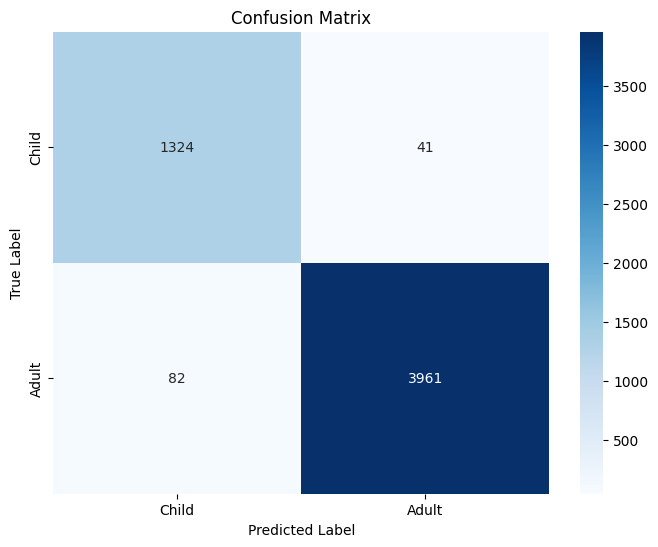

In [2]:
import os
import sys
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# --- 1. GPU Configuration ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{len(gpus)} Physical GPUs, {len(tf.config.list_logical_devices('GPU'))} Logical GPUs")
  except RuntimeError as e:
    print(e)
else:
    print("No GPU found, using CPU.")


# --- 2. Data Loading (from '0-13' and '14+' folders) ---
image_dir = r"D:\Srijan\archive\UTKFace-bincl"
child_image_paths = []
adult_image_paths = []
IMG_SIZE = 128

CLASS_NAMES = ['0-13', '14+']
print(f"Scanning and separating images by class from: {image_dir}")

if not os.path.isdir(image_dir):
    print(f"--> ERROR: The directory does not exist. Please double-check the path: {image_dir}")
    sys.exit()

child_folder_path = os.path.join(image_dir, CLASS_NAMES[0])
if os.path.isdir(child_folder_path):
    for filename in tqdm(os.listdir(child_folder_path), desc=f"Scanning '{CLASS_NAMES[0]}'"):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            child_image_paths.append(os.path.join(child_folder_path, filename))

adult_folder_path = os.path.join(image_dir, CLASS_NAMES[1])
if os.path.isdir(adult_folder_path):
    for filename in tqdm(os.listdir(adult_folder_path), desc=f"Scanning '{CLASS_NAMES[1]}'"):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            adult_image_paths.append(os.path.join(adult_folder_path, filename))

if not child_image_paths or not adult_image_paths:
    print(f"ERROR: Not enough images found for both classes. Check subfolder names and contents.")
    sys.exit()

print(f"\nFound {len(child_image_paths)} images for Class 0 (Child, 0-13)")
print(f"Found {len(adult_image_paths)} images for Class 1 (Adult, 14+)")

all_paths = child_image_paths + adult_image_paths
all_labels = [0] * len(child_image_paths) + [1] * len(adult_image_paths)

# --- 3. Data Splitting ---
path_train_val, path_test, y_train_val, y_test = train_test_split(
    all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

child_paths_train_val = [p for p, l in zip(path_train_val, y_train_val) if l == 0]
adult_paths_train_val = [p for p, l in zip(path_train_val, y_train_val) if l == 1]

# --- 4. Create Data Pipelines with Balanced Batch Sampling ---
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), # Increased rotation
    layers.RandomZoom(0.1),
], name='data_augmentation')

def parse_and_augment_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = data_augmentation(image, training=True)
    image = image / 255.0
    return image, label

def parse_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

child_ds_train = tf.data.Dataset.from_tensor_slices((child_paths_train_val, [0] * len(child_paths_train_val))).shuffle(len(child_paths_train_val)).repeat()
adult_ds_train = tf.data.Dataset.from_tensor_slices((adult_paths_train_val, [1] * len(adult_paths_train_val))).shuffle(len(adult_paths_train_val)).repeat()

train_ds = tf.data.experimental.sample_from_datasets([child_ds_train, adult_ds_train], weights=[0.5, 0.5])
train_ds = train_ds.map(parse_and_augment_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

path_train, path_val, y_train, y_val = train_test_split(path_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
val_ds = tf.data.Dataset.from_tensor_slices((path_val, y_val)).map(parse_image, AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((path_test, y_test)).map(parse_image, AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# --- 5. Model Architecture for Classification ---
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False
inputs = layers.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# --- 6. Callbacks & Compilation for Classification ---
# *** KEY CHANGE: Add ModelCheckpoint to save the best model automatically ***
model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5', # Filepath to save the model
    monitor='val_loss',
    save_best_only=True, # Only save if val_loss improves
    verbose=1
)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False) # restore_best_weights is no longer needed
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

# --- 7. Train Just the Head ---
print("\n--- Training the custom head ---")
steps_per_epoch = len(path_train) // BATCH_SIZE
history = model.fit(train_ds, epochs=50, steps_per_epoch=steps_per_epoch, callbacks=[early_stopping, reduce_lr, model_checkpoint], validation_data=val_ds)

# --- 8. Fine-Tuning ---
print("\n--- Starting fine-tuning ---")
# *** KEY CHANGE: Load the best weights before fine-tuning ***
print("Loading best weights from head training...")
model.load_weights('best_model.h5')

base_model.trainable = True
for layer in base_model.layers[:80]:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
history_fine = model.fit(train_ds, epochs=50, steps_per_epoch=steps_per_epoch, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])

# --- 9. Evaluate the Final Model ---
print("\n--- Evaluating final model on the test set ---")
# *** KEY CHANGE: Load the absolute best weights from the entire run before final evaluation ***
print("Loading best weights from the entire training process for final evaluation...")
model.load_weights('best_model.h5')

loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")
print("\n--- Classification Report ---")
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32")
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print(classification_report(y_true, y_pred, target_names=['Child (0-13)', 'Adult (14+)']))
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult'], yticklabels=['Child', 'Adult'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Minimum validation loss: 0.1717577576637268


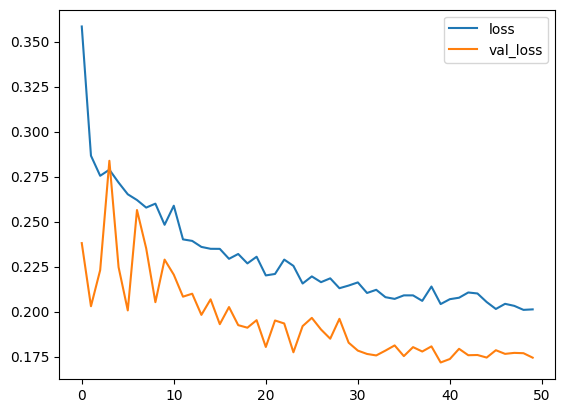

In [7]:
import matplotlib
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))


--- Evaluating final model on the test set ---
Loading best weights from the entire training process for final evaluation...
85/85 [==============================] - 4s 42ms/step - loss: 0.0661 - accuracy: 0.9773
Final Test Loss: 0.0661
Final Test Accuracy: 97.73%

--- Classification Report ---
85/85 [==============================] - 3s 40ms/step
              precision    recall  f1-score   support

Child (0-13)       0.94      0.97      0.96      1365
 Adult (14+)       0.99      0.98      0.98      4043

    accuracy                           0.98      5408
   macro avg       0.97      0.97      0.97      5408
weighted avg       0.98      0.98      0.98      5408


--- Confusion Matrix ---


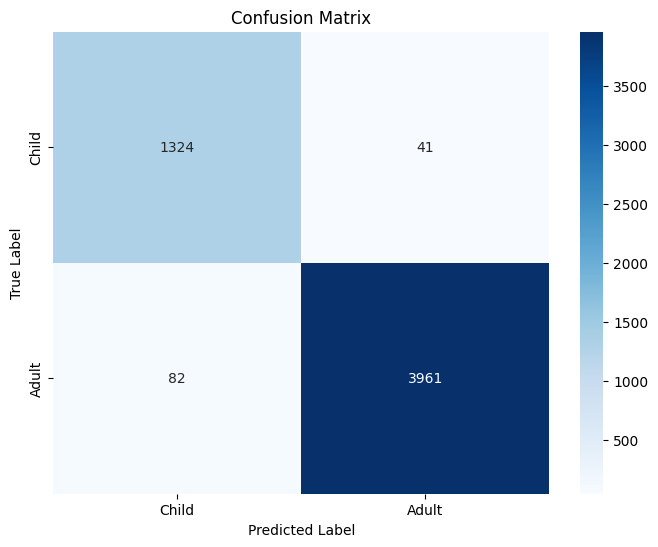

In [4]:
print("\n--- Evaluating final model on the test set ---")
# *** KEY CHANGE: Load the absolute best weights from the entire run before final evaluation ***
print("Loading best weights from the entire training process for final evaluation...")
model.load_weights('best_model.h5')

loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")
print("\n--- Classification Report ---")
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32")
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print(classification_report(y_true, y_pred, target_names=['Child (0-13)', 'Adult (14+)']))
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult'], yticklabels=['Child', 'Adult'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [47]:
# --- 12. Save the Final Model and Scaler for Future Use ---
import joblib

print("\n--- Saving final model ---")
model.save("best_model.h5")
print("Model saved successfully as best_model.h5")


--- Saving final model ---
Model saved successfully as best_model.h5


In [48]:
import tensorflow as tf

# Load your best Keras model
model = tf.keras.models.load_model('best_model.h5')

# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Perform the conversion (no optimizations)
tflite_model = converter.convert()

# Save the final model for your Flutter app
with open('best_model1.tflite', 'wb') as f:
  f.write(tflite_model)

print("Successfully converted model to best_model1.tflite")

INFO:tensorflow:Assets written to: C:\Users\trainee\AppData\Local\Temp\tmpba5m5tn6\assets


INFO:tensorflow:Assets written to: C:\Users\trainee\AppData\Local\Temp\tmpba5m5tn6\assets


Successfully converted model to best_model1.tflite


In [51]:
import cv2
import numpy as np
import tensorflow as tf
import os

# --- 1. Configuration ---
KERAS_MODEL_PATH = "best_model.h5"
# We'll create a TFLite model without optimizations as it was more reliable
TFLITE_MODEL_PATH = "best_model1.tflite" 

# --- 2. Convert Keras Model to TensorFlow Lite (if it doesn't exist) ---
if not os.path.exists(TFLITE_MODEL_PATH):
    print(f"TFLite model not found. Converting from {KERAS_MODEL_PATH}...")
    if not os.path.exists(KERAS_MODEL_PATH):
        print(f"ERROR: Keras model '{KERAS_MODEL_PATH}' not found. Please save it from your training script first.")
    else:
        model = tf.keras.models.load_model(KERAS_MODEL_PATH)
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        # No optimizations for maximum compatibility and to match Keras performance
        tflite_model = converter.convert()
        with open(TFLITE_MODEL_PATH, 'wb') as f:
            f.write(tflite_model)
        print(f"Model converted and saved to {TFLITE_MODEL_PATH}")

# --- 3. Load TFLite Model for Inference ---
if os.path.exists(TFLITE_MODEL_PATH):
    print("\n--- Loading TFLite model for testing ---")
    interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print("Model loaded successfully.")

    # --- 4. Prediction Function ---
    def classify_age_from_image(image_path):
        IMG_SIZE = 128
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image from path: {image_path}")
            return None, None
        
        # Convert image from BGR (OpenCV default) to RGB (TensorFlow default)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Pre-process the image exactly as in training
        img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
        img_normalized = img_resized.astype('float32') / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)
        
        # Run inference with the TFLite model
        interpreter.set_tensor(input_details[0]['index'], img_batch)
        interpreter.invoke()
        prediction_prob = interpreter.get_tensor(output_details[0]['index'])
        
        # Get the single probability value
        probability_adult = prediction_prob[0][0]
        
        # Determine the class based on the probability
        if probability_adult > 0.5:
            predicted_class = "Adult (14+)"
        else:
            predicted_class = "Child (0-13)"
            
        return predicted_class, probability_adult

    # --- 5. Test an Image ---
    # IMPORTANT: Replace this with the full path to an image you want to test
    image_to_test = r"C:\Users\trainee\Downloads\17yo.png"

    if os.path.exists(image_to_test):
        predicted_class, probability = classify_age_from_image(image_to_test)
        if predicted_class is not None:
            print(f"\nPrediction: {predicted_class}")
            print(f"Model's confidence (probability of being an Adult): {probability:.2f}")
            
            # Display the image with the prediction
            original_image = cv2.imread(image_to_test)
            text = f"Prediction: {predicted_class}"
            cv2.putText(original_image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            cv2.imshow("Age Classification", original_image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    else:
        print(f"\nERROR: Test image not found at '{image_to_test}'.")
        print("Please update the 'image_to_test' variable with a valid file path.")

else:
    print("\nERROR: Model files not found. Please run the training script and save the model first.")




--- Loading TFLite model for testing ---
Model loaded successfully.

Prediction: Adult (14+)
Model's confidence (probability of being an Adult): 1.00



--- Combining and Saving Training History ---
Training history saved successfully to 'training_history.pkl'
Loading training history from: training_history.pkl
History loaded successfully.


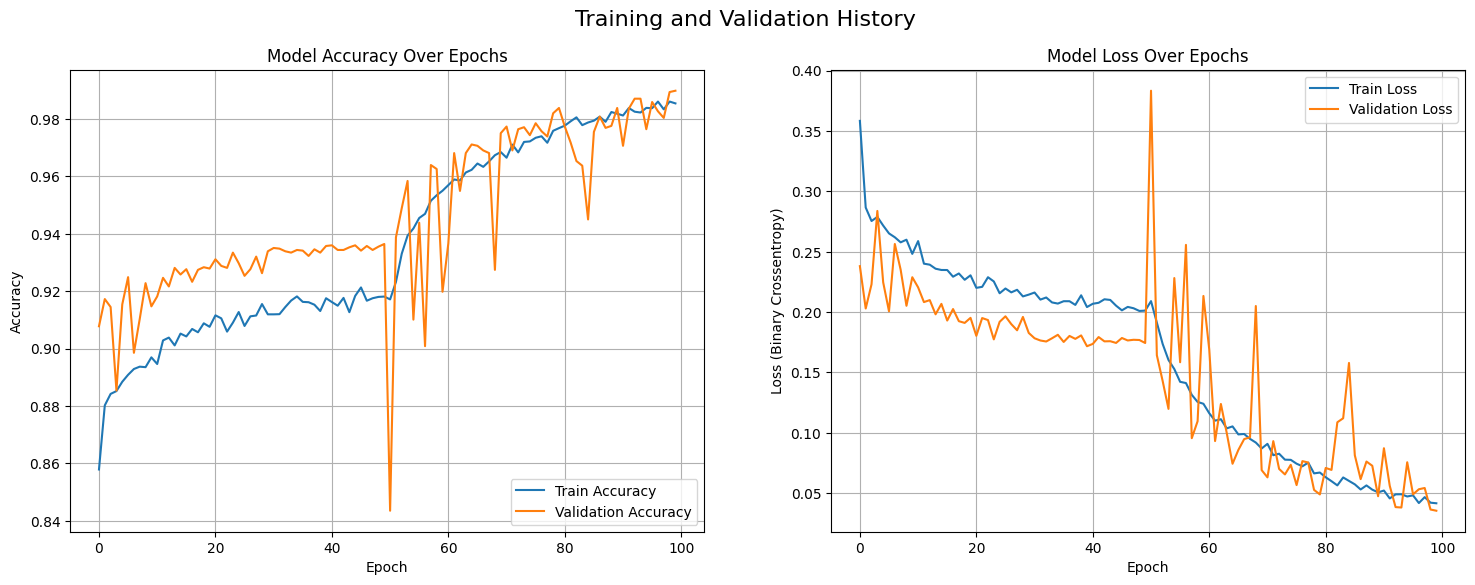

In [8]:
import pickle

print("\n--- Combining and Saving Training History ---")

# Combine the history from head training and fine-tuning safely
full_history = {
    'loss': history.history['loss'] + history_fine.history['loss'],
    'accuracy': history.history['accuracy'] + history_fine.history['accuracy'],
    'val_loss': history.history['val_loss'] + history_fine.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'] + history_fine.history['val_accuracy'],
}

# Save the combined history object to a file
with open('training_history.pkl', 'wb') as file:
    pickle.dump(full_history, file)

print("Training history saved successfully to 'training_history.pkl'")

# --- 1. Configuration ---
# The name of the file where you saved your training history
HISTORY_FILE_PATH = "training_history.pkl"

# --- 2. Load the History File ---
print(f"Loading training history from: {HISTORY_FILE_PATH}")

if not os.path.exists(HISTORY_FILE_PATH):
    print(f"\nERROR: History file not found at '{HISTORY_FILE_PATH}'.")
    print("Please make sure you have run the training script and saved the history object first.")
else:
    try:
        with open(HISTORY_FILE_PATH, 'rb') as file:
            history = pickle.load(file)
        print("History loaded successfully.")

        # --- 3. Plot the Graphs ---
        # Check if the required keys are in the history object
        required_keys = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
        if all(key in history for key in required_keys):
            
            # Create a figure with two subplots (one for accuracy, one for loss)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
            
            # Plot training & validation accuracy values
            ax1.plot(history['accuracy'], label='Train Accuracy')
            ax1.plot(history['val_accuracy'], label='Validation Accuracy')
            ax1.set_title('Model Accuracy Over Epochs')
            ax1.set_ylabel('Accuracy')
            ax1.set_xlabel('Epoch')
            ax1.legend(loc='lower right')
            ax1.grid(True)

            # Plot training & validation loss values
            ax2.plot(history['loss'], label='Train Loss')
            ax2.plot(history['val_loss'], label='Validation Loss')
            ax2.set_title('Model Loss Over Epochs')
            ax2.set_ylabel('Loss (Binary Crossentropy)')
            ax2.set_xlabel('Epoch')
            ax2.legend(loc='upper right')
            ax2.grid(True)

            # Display the plots
            plt.suptitle('Training and Validation History', fontsize=16)
            plt.show()
            
        else:
            print("\nERROR: The loaded history object is missing required keys.")
            print(f"Required keys are: {required_keys}")
            print(f"Found keys: {list(history.keys())}")

    except Exception as e:
        print(f"\nAn error occurred while loading or plotting the history: {e}")
